## GPT Model  (https://ainote.tistory.com/17 참고)
GPT는 말그대로 언어 생성 모델이다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbBynJk%2FbtqWQ8Wztuu%2FPHCSlHY0QYrXOugdOB2Ldk%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>

#### 1. text를 **Tokenize화** 시켜준다.   
   
#### - Input  
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdwqadV%2FbtqWTYGm199%2FXpkp9aFLbUP0o3WoqFGB8k%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>
GPT의 Pre-Training은 Unsupervised Learning이기 때문에 input과 label이 유사하다. GPT에는 window size라는 변수가 있는데 이는 한 Input의 토큰 개수를 의미한다.  

<img src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcpsYqq%2FbtqWQ8PYDyq%2Fdj0J25iMG1k056RtSVWvr0%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>

In [40]:
import h5py
import random
from torch.utils.data import Dataset
 
 
class GPTDataset(Dataset):
    def __init__(self, dataset_path: str, seq_len: int, window_size: int, rng: random.Random):
        self.dataset = h5py.File(dataset_path, 'r')['token_ids']
        self.seq_len = seq_len
        self.window_size = window_size
        self.rng = rng
        self.size = len(self.dataset)
 
    def __len__(self):
        return self.size
 
    def __getitem__(self, idx):
        start_point = self.rng.randint(0, self.size) # 0부터 self.size까지 중 랜덤
        end_point = min(start_point + (window_size + 1), self.size) # 최소 start_point에서 window_size+1만큼 더한거부터 self.size까지
        window = self.dataset[start_point: end_point]  # Windowing
 
        input_ids = window[:-1]
        label_ids = window[1:]
        return input_ids, label_ids

<img src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcUm396%2FbtqWUNj1gW0%2FwAApRYkdvEqbz5cole23IK%2Fimg.png'>

In [5]:
import torch

def create_future_mask(x: torch.Tensor, offset: int = 0) -> torch.Tensor:
 
    seq_len = x.size(-1)  # seq_length
 
    # Create shifted upper triangular matrix.
    future = torch.ones((seq_len, seq_len), dtype=torch.bool, device=x.device)
    future = future.triu(1)
 
    future_mask = future.view((1,) * (x.ndim - 1) + future.size())
    return future_mask.expand(x.shape + future_mask.shape[-1:])  # (b, s, s)

__getitem__ 함수
- start_point : 0 ~ 데이터셋 길이 사이의 임의의 시작점을 고른다.  
- end_point : 한 Sample의 끝점을 고른다.  
- window : Window size + 1개의 연속된 토큰을 슬라이싱한다.   
- input_ids : 첫 번째 토큰부터 window_size개 = Input Ids
- label_ids : 두 번째 토큰부터 window_size개 = Label Ids  
   
모델에 실제로 Input으로 들어가게 되는 Input Ids와 Label Ids는 (batch_size, seq_length)의 shape을 가진다. 모델에는 Input Ids가 들어가고 출력된 Logits과 Label Ids와 비교하게 된다.  
<font color=grey>※ seq_length는 window_size와 동일하다.</font>    
   
#### - Embedding, Dropout
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbgDUif%2FbtqWXaSSaEF%2FtK8uKipeSJc3AgjHXylKz1%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>    
 
- Token Embedding(token들의 차원을 축소하는 과정) : Token Id의 차원은 vocab 개수이다. Vocab이 N개이면 Token Id는 0 ~ N-1의 정수가 될 수 있다. 즉, 0 ~ N-1의 정수를 hidden_size의 벡터로 바꾸는 과정이다. hidden_size는 Embedding 차원이며, GPT-3의 경우 1600이다. Token Embedding을 거치면 Input Ids(Token Id의 배열)이 (batch_size, seq_length, hidden_size)의 shape을 가지게 된다.      
  
- Position Embedding : GPT의 input에는 해당 token의 위치가 어디인지에 대한 정보가 없기 때문에 position embedding으로 위치정보를 추가해준다. (position embedding 후에도 (batch_size, seq_length, hidden_size)의 shape의 벡터를 얻는다.)     
  
- Dropout : Dropout 과정을 거쳐 Masked Attention Layer에 들어갈 Input을 만든다.   
   

In [ ]:
import torch.nn as nn
 
token_embeddings = nn.Embedding(vocab_size, hidden_size)
position_embeddings = nn.Embedding(seq_len, hidden_size)
 
def position_embed(input_ids, position_embeddings):
 
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
 
   position_embedding_vector = position_embeddings(position_ids)
 
    return position_embedding_vector

drop = nn.Dropout(0.1)
final_embed_vector = drop(token_embed_vector + position_embed_vector)

#### Layer Norm  
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fnjf4F%2FbtqW1sZY60v%2FH34y7Pm0EOQvhU6Fe6kQp1%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>   
GPT에서 Layer Normalization은 벡터들의 값을 정규화하여 training 시간을 줄이는 것이 목표이다.   
   

In [ ]:
layer_norm = nn.LayerNorm(hidden_size, eps=1e-5)
ln_vector = layer_norm(final_embed_vector)

#### Masked Multi-Head Self Attention  
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fr4YIv%2FbtqW4iJAjpJ%2FClf87Uckpo5fUTCFuRyqB1%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>    
  
- Masked : 현재 시점 이후의 token을 가림으로서 학습에 참여시키지 않는 것    
  
- Multi : Attention가 2개 이상

In [ ]:
import math
import torch
import torch.nn as nn
from typing import Optional, Tuple
 
 
class AttentionLayer(nn.Module):
 
    def __init__(self, heads: int, dims: int, dropout: float = 0.1):
        super().__init__()
        self.attn = MultiHeadAttention(heads, dropout)
        self.proj_q = nn.Linear(dims, dims)  # (h, h)
        self.proj_k = nn.Linear(dims, dims)  # (h, h)
        self.proj_v = nn.Linear(dims, dims)  # (h, h)
        self.linear = nn.Linear(dims, dims)  # (h, h)
 
    def forward(self,
                q: torch.Tensor,
                k: torch.Tensor,
                v: torch.Tensor,
                past: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
                mask: Optional[torch.Tensor] = None
                ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        
        # Get Query, Key, Value / Shape : (batch_size, seq_length, hidden_size)
        q, k, v = self.proj_q(q), self.proj_k(k), self.proj_v(v)
 
        s = self.attn(q, k, v, mask)
        x = self.linear(s)  # (h, h)
 
        return x, (k, v)

forward 함수
- q, k, v : 들어온 Input Tensor로 Query, Key, Value를 만드는 것이다.  
실제로 GPT가 Pre-training될 때 학습되는 것은 Q, K, V를 만드는 Layer이다.  
들어온 Input Tensor가 (batch_size, seq_length, hidden_size)의 shape을 가지기 때문에 Query, Key, Value 모두 같은 shape을 가진다. (각 token이 모두 Query, Key, Value를 갖는다.)  
- s : Multi-Head Attention을 거치는 것이다. Multi-Head Attention이란 한 개의 Query, Key, Value를 여러개로 쪼개는 것이다.    
 
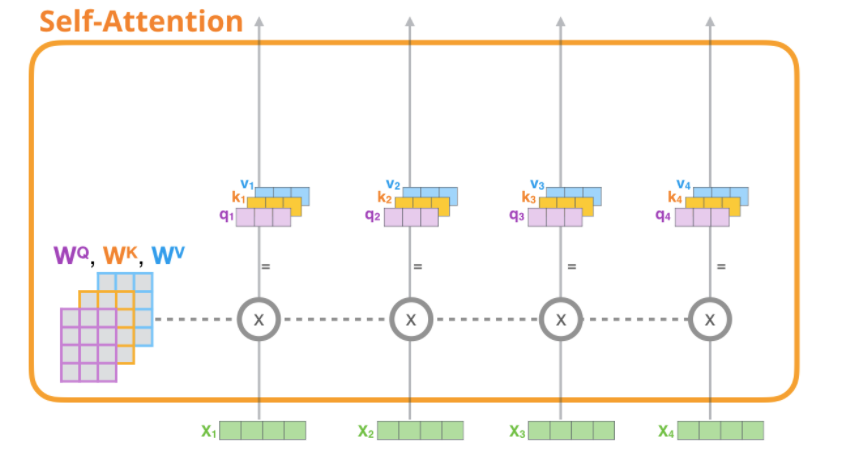
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>  

In [ ]:
import math
import torch
import torch.nn as nn
from typing import Optional, Tuple
 
 
class MultiHeadAttention(object):
 
    def __init__(self, heads: int, dropout: float = 0.1):
        super().__init__(dropout)
        self.heads = heads
        self.dropout = nn.Dropout(dropout)
 
    def forward(self,
                q: torch.Tensor,
                k: torch.Tensor,
                v: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> torch.Tensor:
 
        # Split the tensors to multi-heads.
        # Shape : (batch_size, seq_length, head_num, one_head_len)
        q = q.view(q.size()[:-1] + (self.heads, q.size(-1) // self.heads))
        k = k.view(k.size()[:-1] + (self.heads, k.size(-1) // self.heads))
        v = v.view(v.size()[:-1] + (self.heads, v.size(-1) // self.heads))

        # Shape : (batch_size, head_num, seq_length, one_head_len)
        q = q.transpose(-3, -2)
        k = k.transpose(-3, -2)
        v = v.transpose(-3, -2)
 
        if mask is not None:
            mask = mask.unsqueeze(-3)  # (batch_size, 1, seq_length, seq_length)
            mask = mask.type_as(x)  # (batch_size, head_num, seq_length, seq_length)
 
 
        # Calculate multi-headed attentions and merge them into one.
        k = k.transpose(-2, -1)  # (batch_size, head_num, one_head_len, seq_length)
        num_heads_sqrt = math.sqrt(k.size(-1))  # sqrt(head_num)
        
        # Matrix Multiple Query AND Keys / Divide with sqrt(head_num)
        # Shape : (batch_size, head_num, seq_length, seq_length)
        # -> 각 샘플의 (batch_size) 각 head의 (head_num), 각 token의 (seq_length), 해당 샘플의 다른 모든 토큰들에 대한 Attention값이 된다.
        # 제곱근으로 나누어주는 이유는 빠른 수렴을 위해 가하는 작업이다.
        score = torch.matmul(q, k) / num_heads_sqrt
        
        # Add Large Negative where the mask is true
        # Shape : (batch_size, head_num, seq_length, seq_length)
        # mask를 head의 수만큼 늘려준 뒤, True (1)인 부분에 아주 큰 음수를 곱한다.
        masked_score = score + mask * score.new_tensor(-1e6)
        
        # Softmax
        # float that large negative number has added becomes to zero
        # 큰 음수 값을 곱한 후 softmax를 취했으므로  True였던 부분은 0이 된다.
            ### 밑 그림 참고
        masked_score  = masked_score.softmax(-1)
        # 자기 이후 token들의 attention을 0으로 바꾼 후 dropout 적용
        masked_score  = self.dropout(masked_score)
        
        # Matrix Multiple score and value
        # Shape : (batch_size, head_num, seq_length, one_head_len)
        # 다른 token들과의 Attention score와 value(Embedding vector의 일부)를 곱하여 Attention score를 만든다.
        attention_score = torch.matmul(x, v)
        
        # (batch_size, seq_length, head_num, one_head_len)
        attention_score = attention_score.transpose(-3, -2).contiguous()
 
        # (batch_size, seq_length, hidden_size)
        original_shape = q.size()[:-3] + (q.size(-2), v.size(-1) * self.heads)
        attention_score = attention_score.view(original_shape)
 
        return attention_score

<img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcstvVa%2FbtqW1sTaulu%2FL12GGUr2cxnhEduksJYSC1%2Fimg.png'>
<img src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FGNo1i%2FbtqWVQ8EeZD%2FehXu1twLd9lM4myEoru2Y0%2Fimg.png'>
위는 큰 음수를 곱한 후 sofrmax를 취하여 자기 이후의 token들에 대한 attention값을 삭제하는 효과를 나타낸 그림이다.

forward 함수   
Query, Key, Value를 여러개로 분할하는 것을 볼 수 있다. hidden_size 차원의 벡터였던 각 토큰의 Query, Key, Value를 각각 head_num개로 쪼개었다. 한 쌍의 Query, Key, Value를 Head라고 하기 때문에 GPT의 Attention은 한 토큰에 Query, Key, Value 쌍이 여러개인 Multi-Head Attention이라고 하는 것이다.  
   
이후 Query와 Key를 행렬 곱하여 score를 만들어주고, 현재 시점 이후의 token들을 지워 masking 과정을 진행하여 Masked score를 만든다.  
Masked score에 Value 값을 행렬 곱하여 Attention score를 만들어준다. 
  
#### Add(Skip connection) & Layer Normalization  
<img src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F5nGvy%2FbtqWVQ8E3GJ%2Fs0MK6tyTkCkubgQ5v8rJqK%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>  
Transformer Layer에 처음 들어온 Vector를 Masked Multi-Head Self Attention을 거친 Vector와 더하는 것을 Skip Connection이라고 한다. 이전 층에 대한 정보 손실을 막기 위해 사용된다.
  
#### Feed Forward Neural Network  
<img src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fk2Qi7%2FbtqW1sFE9Ff%2FtDHez52IjnQR5gyn5AR5z0%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>  
Nomalize된 Vector의 차원을 키웠다 줄이는 과정으로 이는 Embedding Vector 차원(hidden_size)의 병목(전체 시스템이나 성능이 하나의 구성요소로 인해 제한을 받는 현상)을 줄여주는 효과가 있다고 한다. GPT에서는 hidden_size를 4배 키웠다 줄이며 이는 Transformer에서 그랬기 때문에 그대로 가져다 쓴 것이다.  
   

In [ ]:
class PositionWiseFeedForward(nn.Sequential):
 
    def __init__(self, dims: int, rate: int = 4, dropout: float = 0.1):
        super().__init__(
            nn.Linear(dims, dims * rate),  # (b, s, 4 * h)
            gelu(),  # Activation Function
            nn.Dropout(dropout),
            nn.Linear(dims * rate, dims))  # (b, s, h)

#### Add(Skip connection)  
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdDGtKE%2FbtqWXaZQwXW%2FGooJQUy24do7LspMLyPVzk%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>  
Masked Multi-Head Attention을 거쳐서 나온 벡터와 Feed Forward Neural Network를 거쳐서 나온 벡터를 더해준다. Normalization은 다음 Transformer Layer의 첫부분에서 하게 된다. (GPT-1은 12번, GPT-3는 48번)    
   
#### Predicting Next Token   
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fcl5NpE%2FbtqWWtk2MfL%2FIXJwpclrFUXRFrPFn7XNCk%2Fimg.png'>
<center><font color=grey>[출처]https://ainote.tistory.com/17</font></center>   
  
- Layer Norm : 마지막 Transformer Layer에서는 Normalization을 거치지 않았기 때문에 Normalization을 해준다.   
- Output Embedding : Token Embedding은 0 ~ vocab_size -1의 정수를 hidden_size의 벡터로 바꾸는 과정이었다면 Output Embedding은 반대로 hidden_size 벡터를 vocab_size로 바꾸는 과정이다. 이때, Token Embedding의 weight를 사용한다. 즉, Token Embedding과 Output Embedding은 동일한 weight를 사용하는 Linear Layer이다.   
- Softmax : Output Embedding을 거쳐서 나온 logit에 Softmax를 취해 다음에 각 토큰이 올 확률을 구한다. 이후 해당 값과 Label Id의 CrossEntropy를 사용하여 loss를 구한다.